In [32]:
#libraries
library(pracma)
library(ggplot2)
library(maps) 
library(patchwork)
library(dplyr)

rm(list = ls())

setwd("/home/yow004/Documents/GitHub/NonergodicSD")

#user functions
source('R_lib/regression/inla/regression_inla_model1_unbounded_hyp.R')



In [33]:
#input file
flatfile_fname <- 'data/compile_all.csv'

df_flatfile <- read.csv(flatfile_fname)

  #UTM zone
  utm_zone <- unique(df_flatfile$UTMzone)
  utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))

In [34]:
#event index
event<-df_flatfile %>% group_by(eqid) %>% filter(row_number()==1)




Warning message:
“Removed 335 row(s) containing missing values (geom_path).”
Warning message:
“Removed 335 row(s) containing missing values (geom_path).”
Warning message:
“Removed 335 row(s) containing missing values (geom_path).”
Warning message:
“Removed 335 row(s) containing missing values (geom_path).”


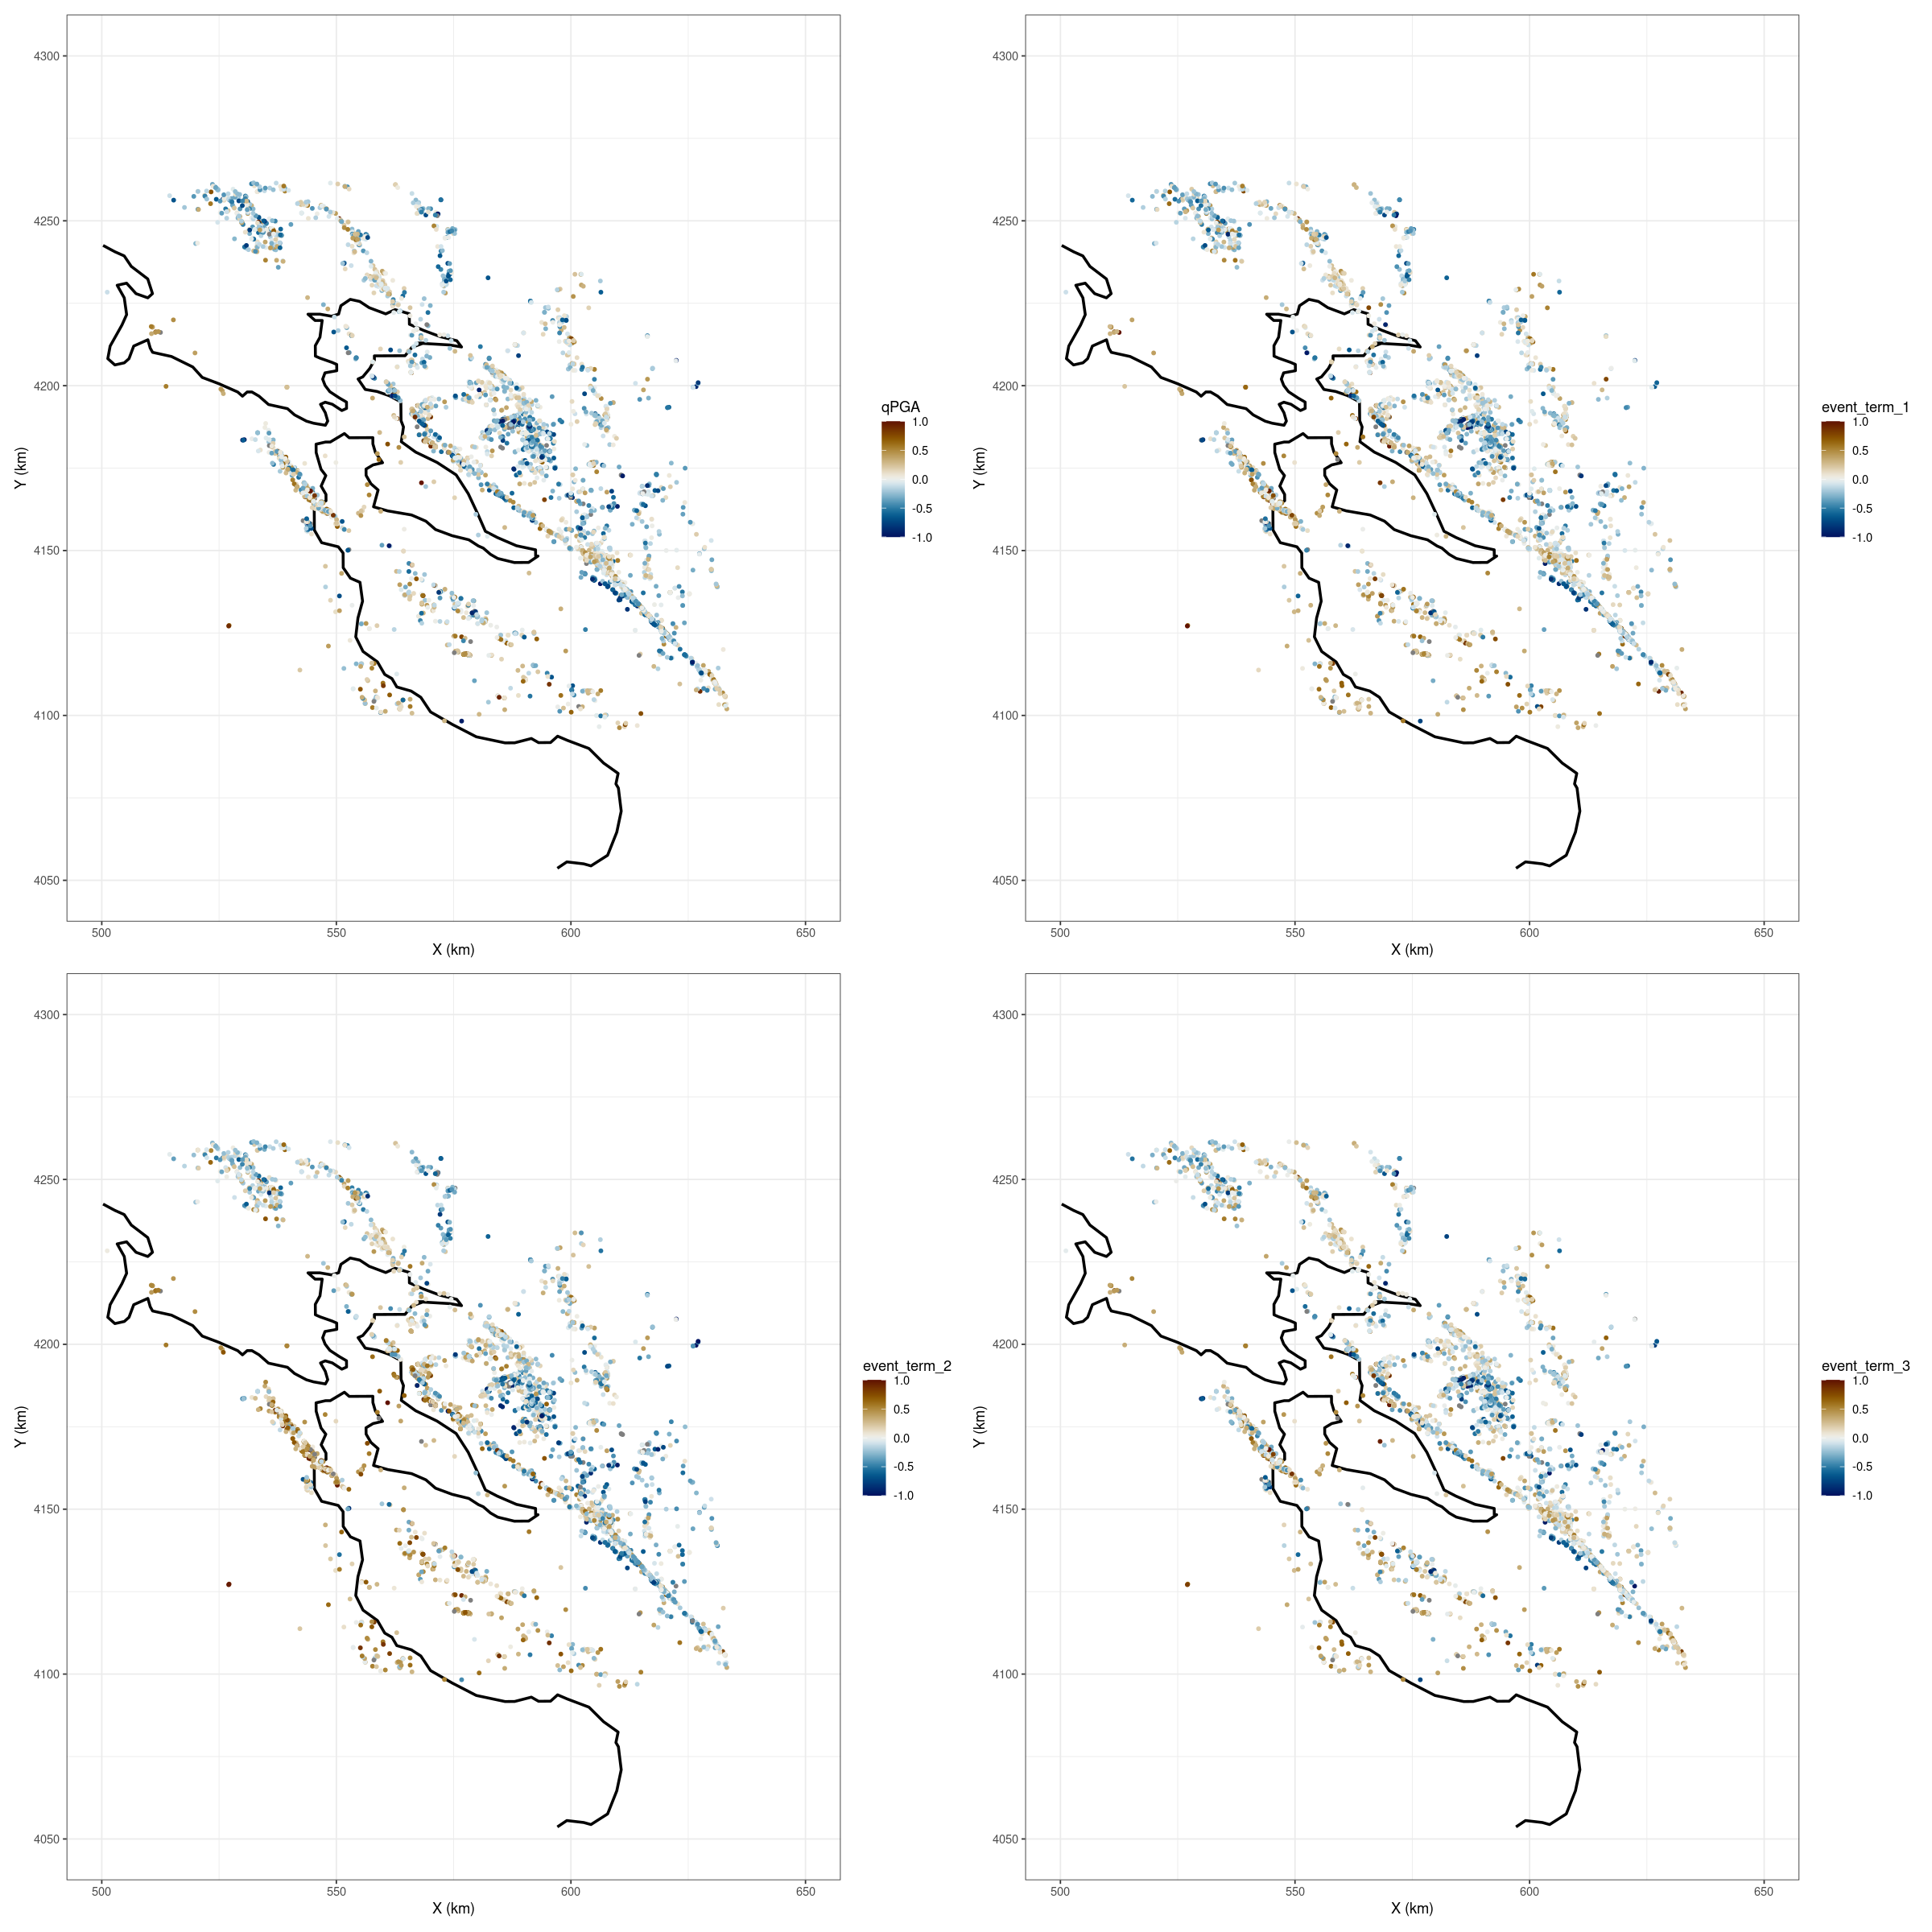

In [66]:
options(repr.plot.width=20, repr.plot.height=20)

#California
map_ca <- subset( map_data("state"), region %in% c("california"))
map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000

#Earthquake - Station Mesh
  pl_mesh  <- ggplot() + theme_bw() + 
              geom_path(data=map_ca, aes(x=X,y=Y), color='black',size=1) +
              #geom_point(data=df_flatfile, aes(x=eqX,y=eqY),size=0.5,color='red') +
              labs(x="X (km)", y="Y (km)") +
              xlim(500,650) + ylim(4050,4300) 

cmap<-"vik"
zlim<-c(-1,1)
dic<- 1

p1 <- pl_mesh+geom_point(data=event, aes(x=eqX,y=eqY,color=qPGA),size=1) +scico::scale_colour_scico(palette = cmap,limits=zlim,direction=dic)
p2 <- pl_mesh+geom_point(data=event, aes(x=eqX,y=eqY,color=event_term_1),size=1) +scico::scale_colour_scico(palette = cmap,limits=zlim,direction=dic)
p3 <- pl_mesh+geom_point(data=event, aes(x=eqX,y=eqY,color=event_term_2),size=1) +scico::scale_colour_scico(palette = cmap,limits=zlim,direction=dic)
p4 <- pl_mesh+geom_point(data=event, aes(x=eqX,y=eqY,color=event_term_3),size=1) +scico::scale_colour_scico(palette = cmap,limits=zlim,direction=dic)


p1+p2 + p3+p4+ plot_layout(ncol = 2)

